***
## Importar librerías y dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Carga de datos

In [4]:
data = pd.read_excel('bankdata.xlsx')
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Year,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,yes


## Transformacion de datos

- Agregar una columna con el número del mes (que no sea str sino int). Notar que no están todos los meses, y que los que están son irregulares. Debemos identificar de alguna forma a qué año corresponde c/u para crear una línea temporal.


In [7]:
dic={   'jan': 1,
        'feb': 2,
        'mar': 3,  
        'apr': 4,
        'may': 5,
        'jun': 6,
        'jul': 7,
        'aug': 8,
        'sep': 9,
        'oct': 10,
        'nov': 11,
        'dec': 12}
data['month'] =data['month'].replace(dic)

In [8]:
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Year,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
1,57,services,married,high.school,unknown,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
2,37,services,married,high.school,no,yes,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no


- Agregar una col que tenga la var intermensual de inflación (surge de la resta de: (IPC(mes+1) - IPC(mes)) / IPC(mes). Para el primer mes deberíamos poner 0, porque no tenemos un valor previo. Para el resto podemos calcularlo.

In [10]:
dataCopy = data.copy()
dataCopy.rename(columns={'month': 'month_Column','Year': 'Year_Column'}, inplace=True)
agrupamiento = dataCopy.groupby(['Year_Column', 'month_Column'])['cons.price.idx'].mean()
# Se valida que la los datos de la tabla es el mismo aplicando las diferentes funciones
# agrupamiento = data.groupby(['Year_Column', 'month_Column'])['cons.price.idx'].first()
# agrupamiento = data.groupby(['Year_Column', 'month_Column'])['cons.price.idx'].min()
# agrupamiento = data.groupby(['Year_Column', 'month_Column'])['cons.price.idx'].max()
# agrupamiento = data.groupby(['Year_Column', 'month_Column'])['cons.price.idx'].last()

df_resultado = agrupamiento.reset_index()
# df_resultado

# Crear una nueva columna 'IPC_mes_siguiente' que desplaza los valores de IPC un mes hacia adelante
df_resultado['IPC_mes_siguiente'] = df_resultado['cons.price.idx'].shift(-1)

# Función para calcular la variación intermensual
def calcular_variacion(row):
    if pd.isna(row['IPC_mes_siguiente']):
        return 0  # TODO: Agregar calculo de ((ICP_dec_2010 - ICP_nov_2010) / ICP_nov_2010) * 100
    else:
        return ((row['IPC_mes_siguiente'] - row['cons.price.idx']) / row['cons.price.idx']) * 100

# Aplicar la función a cada fila y crear la columna 'variacion_inflacion'
df_resultado['variacion_inflacion'] = df_resultado.apply(calcular_variacion, axis=1)

# Eliminar la columna auxiliar 'IPC_mes_siguiente'
df_resultado = df_resultado.drop('IPC_mes_siguiente', axis=1)

# Mostrar los resultados
df_resultado

,Year_Column,month_Column,cons.price.idx,variacion_inflacion
0,2008,5,93.994,0.501096
1,2008,6,94.465,-0.579050
2,2008,7,93.918,-0.504696
3,2008,8,93.444,0.378837
4,2008,10,93.798,-0.637540
5,2008,11,93.200,-0.476395
6,2008,12,92.756,0.093794
7,2009,3,92.843,0.249884
8,2009,4,93.075,-0.195541
9,2009,5,92.893,0.075356


# Dataset explanation

#### **Dataset from a bank from a telemarketing campaing**

##### Demographic Information:
    age: Age of the individual.
    job: Type of job (e.g., blue-collar, management).
    marital: Marital status (e.g., single, married, divorced).
    education: Education level (e.g., primary, secondary, tertiary).
    default: Has the individual defaulted on a loan? (yes/no)
##### Housing and Financial Information:
    housing: Housing loan status (yes/no).
    loan: Personal loan status (yes/no).
    contact: Contact method (e.g., cellular, telephone).
    month: Month of the last contact.
    day_of_week: Day of the week of the last contact.
    duration: Last contact duration in seconds.
    campaign: Number of contacts performed during this campaign for this client.
    pdays: Number of days that passed after the previous campaign for this client.   
    previous: Number of contacts performed before this campaign for this client.
    poutcome: Outcome of the previous marketing campaign (e.g., success, failure, unknown).

**__According to the dataset, the column "duration" should be removed because it highly affects the output (duration=0 --> 'no', other duration -->'yes'), and the duration is only known after the call is done.__**


##### Economic Indicators (they are macro-economical indicators):
    - emp.var.rate: Employment variation rate - QUARTERLY indicator of the variation in the number of employed people. Represented with floatings.(see cons.price.idx for more info.)
    - cons.price.idx: Consumer price index - monthly indicator of the variation in consumer prices. (Same as IPC in ARGENTINA). It is represented with floatings, e.g.: 1.1 means the employment increased by 1.1% ; -3.2 means the employment decreased by -3.2%.
    - cons.conf.idx: Consumer confidence index - monthly measure of consumer sentiment about the overall economic health of a country. It's often used as an indicator of future economic activity.
    - euribor3m: 3-month Euribor rate - interest rate at which banks in the Eurozone lend money to each other for a 3-month period. Different values can lead to higher/lower interest rates for consumers on loans and mortgages.
    - nr.employed: Number of employees - quarterly indicator of the total number of employed people.
##### Target Variable:
    y: Has the client subscribed a term deposit (yes/no)?. A term deposit is a deposit that a bank or financial insitution offers with a fixed rate in which your money will be returned back at a specific maturity time. In spanish, we call it "Plazo fijo".


# First exploratory analysis

### Things we can do:
1. Find missing values
2. Explore the categorical features
3. Explore the distribution of the categorical features
4. Relationship between categorical features and target value
5. Explore numerical features - which ones are discrete / continuous?
6. Explore the relation between numerical features and target value
7. Find outliers
8. Correlation between numerical features
9. Pair-plots.
10. Is the dataset balanced or not?
11. Create new features
12. iterate the process to further enhance the analysis

### Drop duration column. It won't be used for the analysis.

In [16]:
data.drop('duration', axis=1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Year,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
1,57,services,married,high.school,unknown,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
2,37,services,married,high.school,no,yes,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
3,40,admin.,married,basic.6y,no,no,no,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
4,56,services,married,high.school,no,no,yes,telephone,5,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,2008,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,11,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,11,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,no
41185,56,retired,married,university.degree,no,yes,no,cellular,11,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,no
41186,44,technician,married,professional.course,no,no,no,cellular,11,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,2010,yes


### Nulls, type of data per column, number of unique data per column

In [18]:
missing_values = data.isnull().sum().sum()
print(f' "there are {missing_values} missing values" ') 

 "there are 0 missing values" 


In [19]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month               int64
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
Year                int64
y                  object
dtype: object

In [20]:
data.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
Year                 3
y                    2
dtype: int64

In [21]:
# There are duplicate rows in our dataset. We can confirm it using the duplicated function.
print(f' "there are {data.duplicated().sum()} duplicated values" ') #comment this row and run the cell to see the duplicated rows.
data_duplicates = data.copy()
data_duplicates['duplicates'] = data.duplicated()
duplicate_rows = data_duplicates[data_duplicates['duplicates'] == True]


 "there are 12 duplicated values" 


In [22]:
#data['nr.employed'].unique()
#data['cons.price.idx'].unique()
#data['cons.conf.idx'].unique()
#data['euribor3m'].unique()
#data['nr.employed'].unique()
#list = data['age'].unique().copy()
#list.sort()
#list
duplicate_rows

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Year,y,duplicates
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,5,thu,...,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,2008,no,True
12261,36,retired,married,unknown,no,no,no,telephone,7,thu,...,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,2008,no,True
14234,27,technician,single,professional.course,no,no,no,cellular,7,mon,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,2008,no,True
16956,47,technician,divorced,high.school,no,yes,no,cellular,7,thu,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,2008,no,True
18465,32,technician,single,professional.course,no,yes,no,cellular,7,thu,...,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,2008,no,True
20216,55,services,married,high.school,unknown,no,no,cellular,8,mon,...,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,2008,no,True
20534,41,technician,married,professional.course,no,yes,no,cellular,8,tue,...,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,2008,no,True
25217,39,admin.,married,university.degree,no,no,no,cellular,11,tue,...,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,2008,no,True
28477,24,services,single,high.school,no,yes,no,cellular,4,tue,...,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,2009,no,True
32516,35,admin.,married,university.degree,no,yes,no,cellular,5,fri,...,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,2009,no,True


### Exploring the variables with PLOTS

#### Ploting the distribution of each variable and key takeaways.

In [25]:
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
print(f' There are {len(categorical_columns)} categorical columns \n\n')
for column in categorical_columns:
    unique_values = data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

 There are 10 categorical columns 


Column 'job' has 12 unique values.
Column 'marital' has 4 unique values.
Column 'education' has 8 unique values.
Column 'default' has 3 unique values.
Column 'housing' has 3 unique values.
Column 'loan' has 3 unique values.
Column 'contact' has 2 unique values.
Column 'day_of_week' has 5 unique values.
Column 'poutcome' has 3 unique values.
Column 'y' has 2 unique values.


Columns **job, month** and **education** have the highest number of unique values.

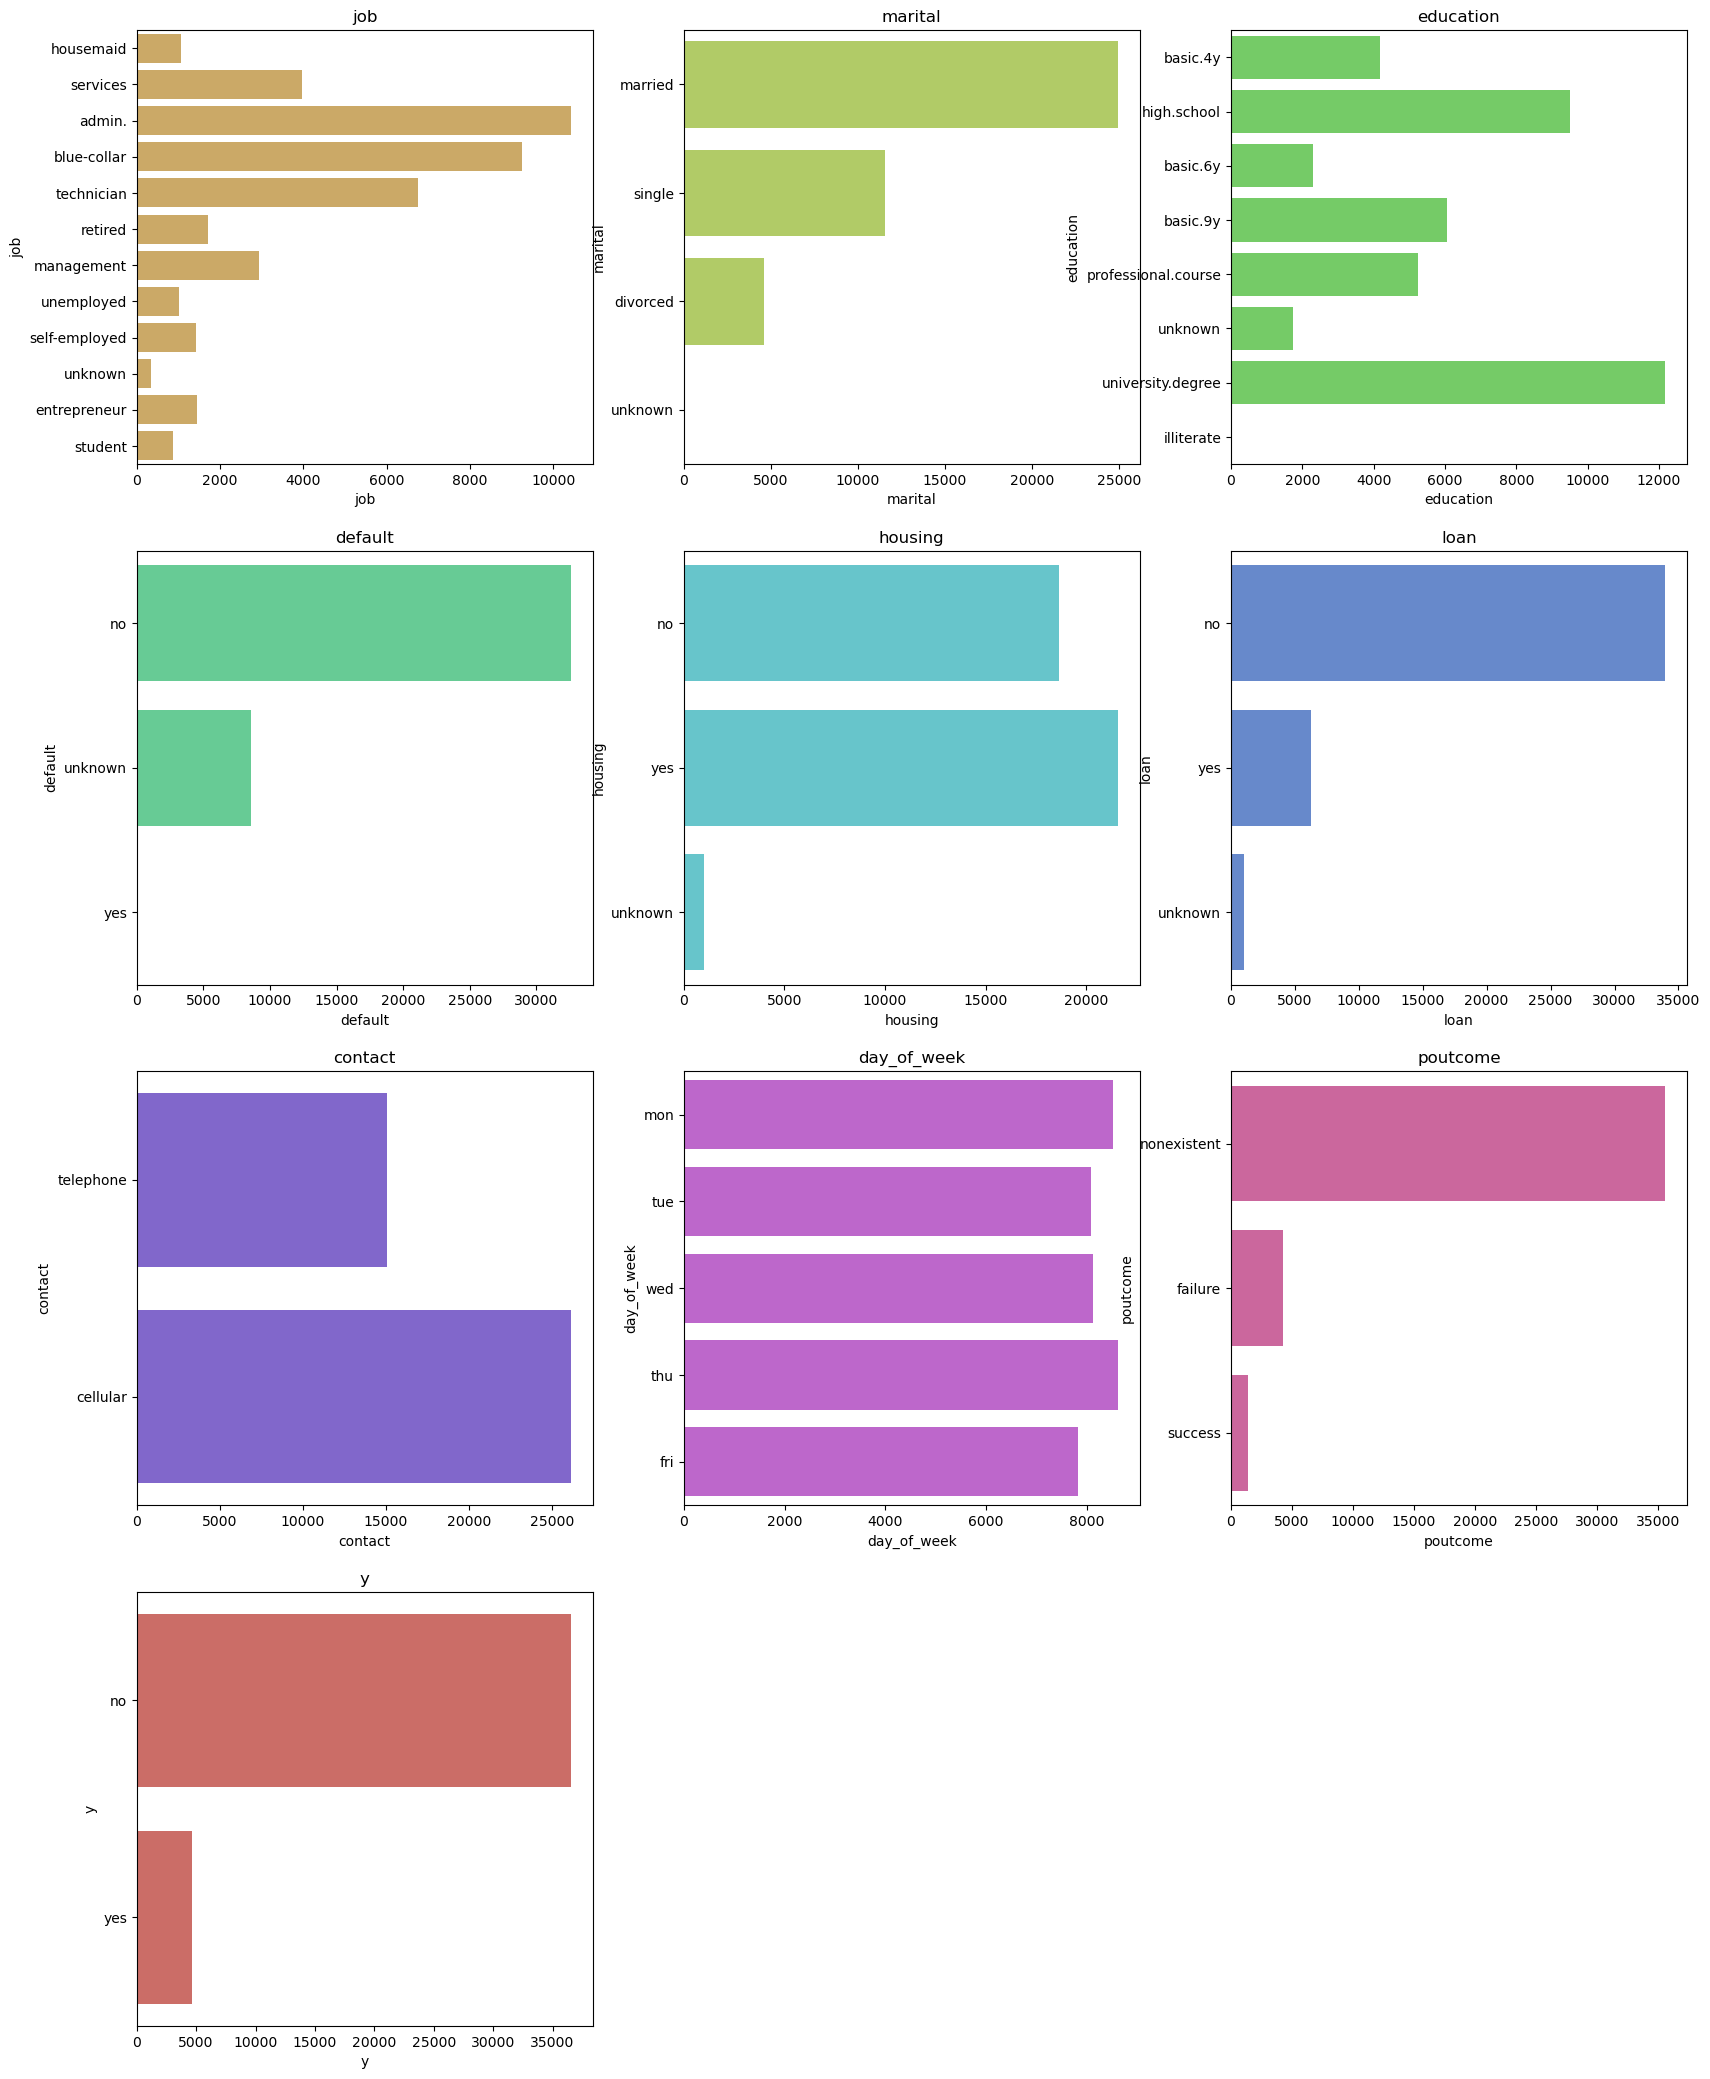

In [27]:
plt.figure(figsize=(20,80), facecolor = 'white')
plotnumber=1
color_palette = sns.color_palette("hls", len(categorical_columns))  # Adjust the palette as needed

for categorical_column in categorical_columns:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_column, data=data, ax=ax, color=color_palette[plotnumber % len(color_palette)])
    plt.xlabel(categorical_column)
    plt.title(categorical_column)
    plotnumber+=1

plt.show()

*OBSERVACIONES:*
- Los trabajos predominantes en la clientela son de tipo **admin, blue-collar** y **technician**.
- La mayoría de los clientes están **casados**.
- La mayoría de los clientes tienen un título **universitario** o han alcanzado como máximo un estudio **secundario completo**.
- La gran mayoría de los clientes **no ha solicitado préstamos o no tiene préstamos pendientes**, pero cuando a housing (hipoteca) se refiere, hay una distribución similar entre aquellos que han solicitado y aquellos que no.
- La mayoría de las llamadas han sido realizadas a teléfonos celulares y en el mes de mayo.
- **Los resultados (outcome/label) no están balanceados, estamos en frente de un dataset DESBALANCEADO**.

#### Categoricals vs numericals

We are going to **remove** the columns which have the highest number of unique variables. This will allow us to perform a better visualization.
The columns to drop are: **job, month and education.**

In [31]:
categorical_columns_removed = categorical_columns.copy()
columns_to_remove = ['job','education', 'y']
for column in columns_to_remove:
    categorical_columns_removed.remove(column)

categorical_columns_removed

['marital', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome']

.



***Plot for 'marital', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome'***

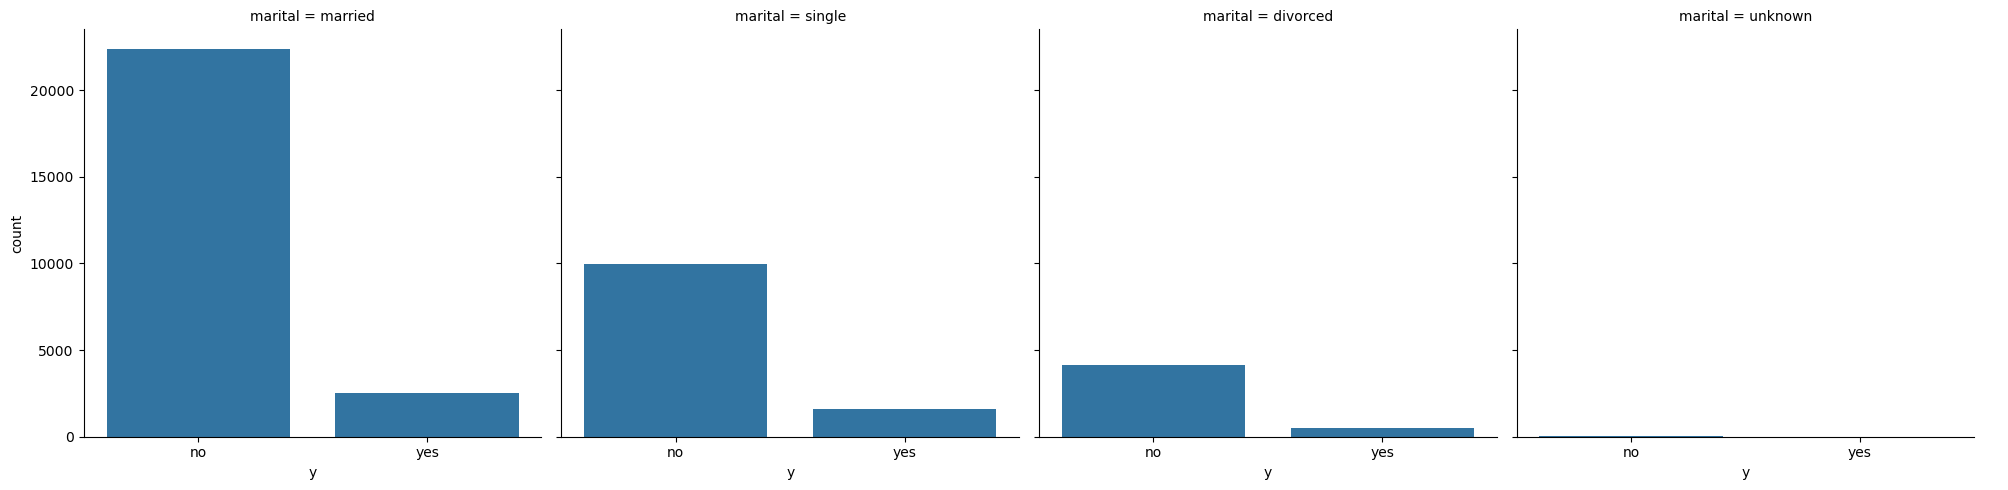

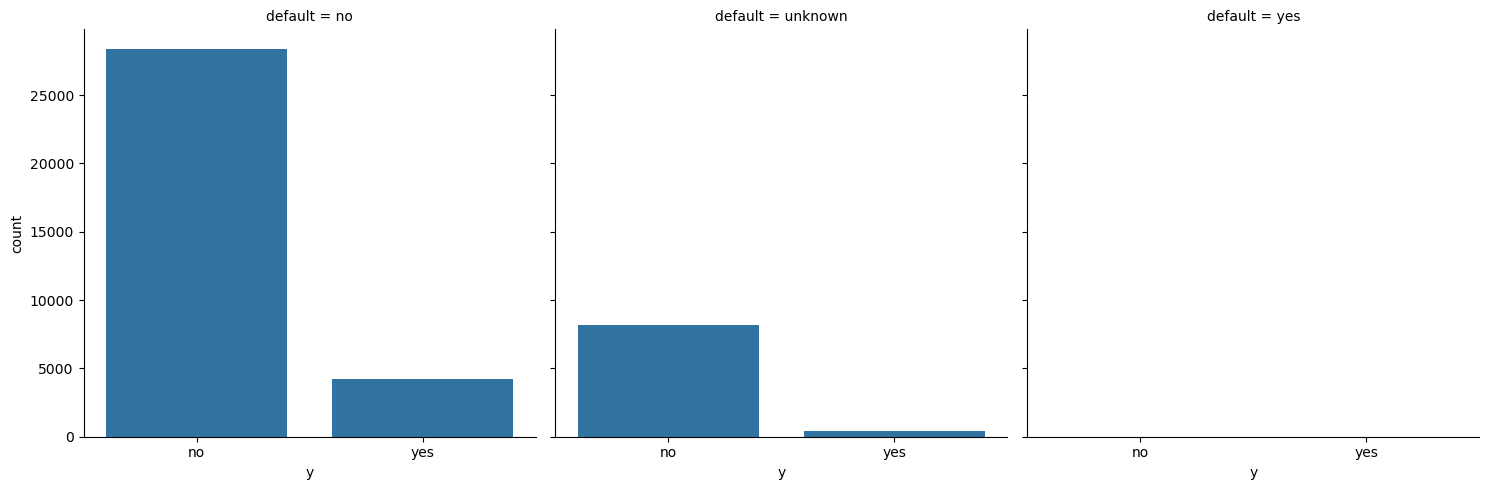

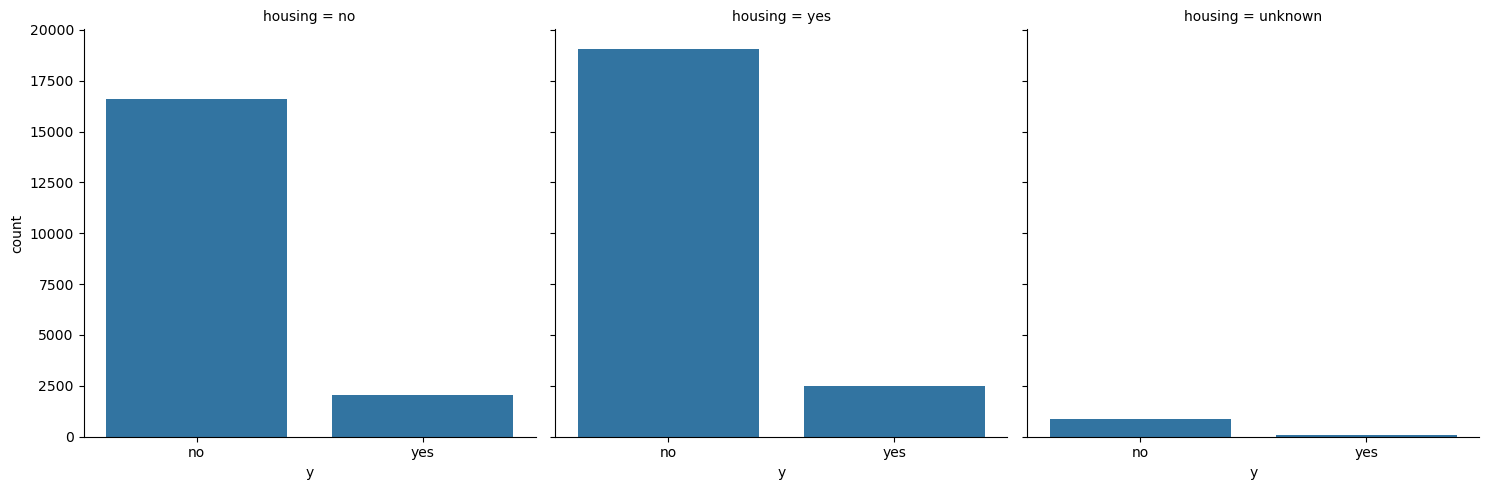

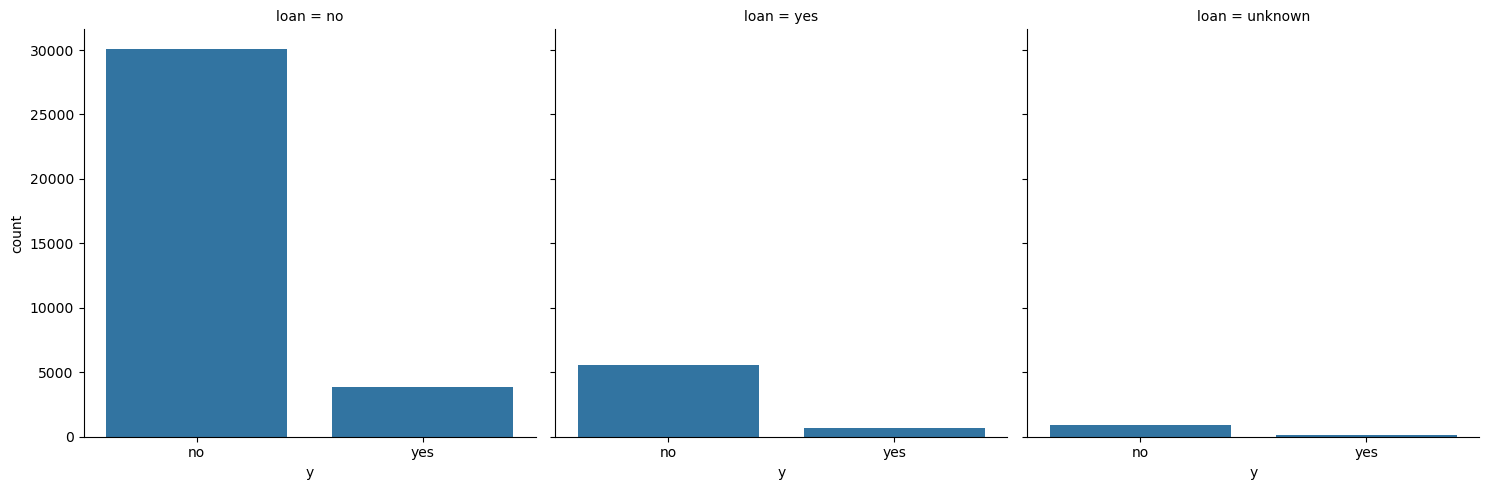

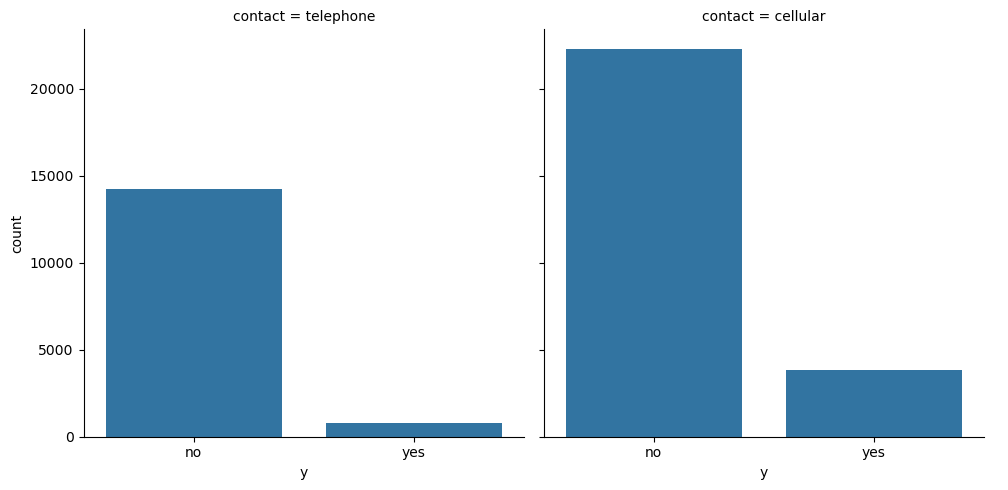

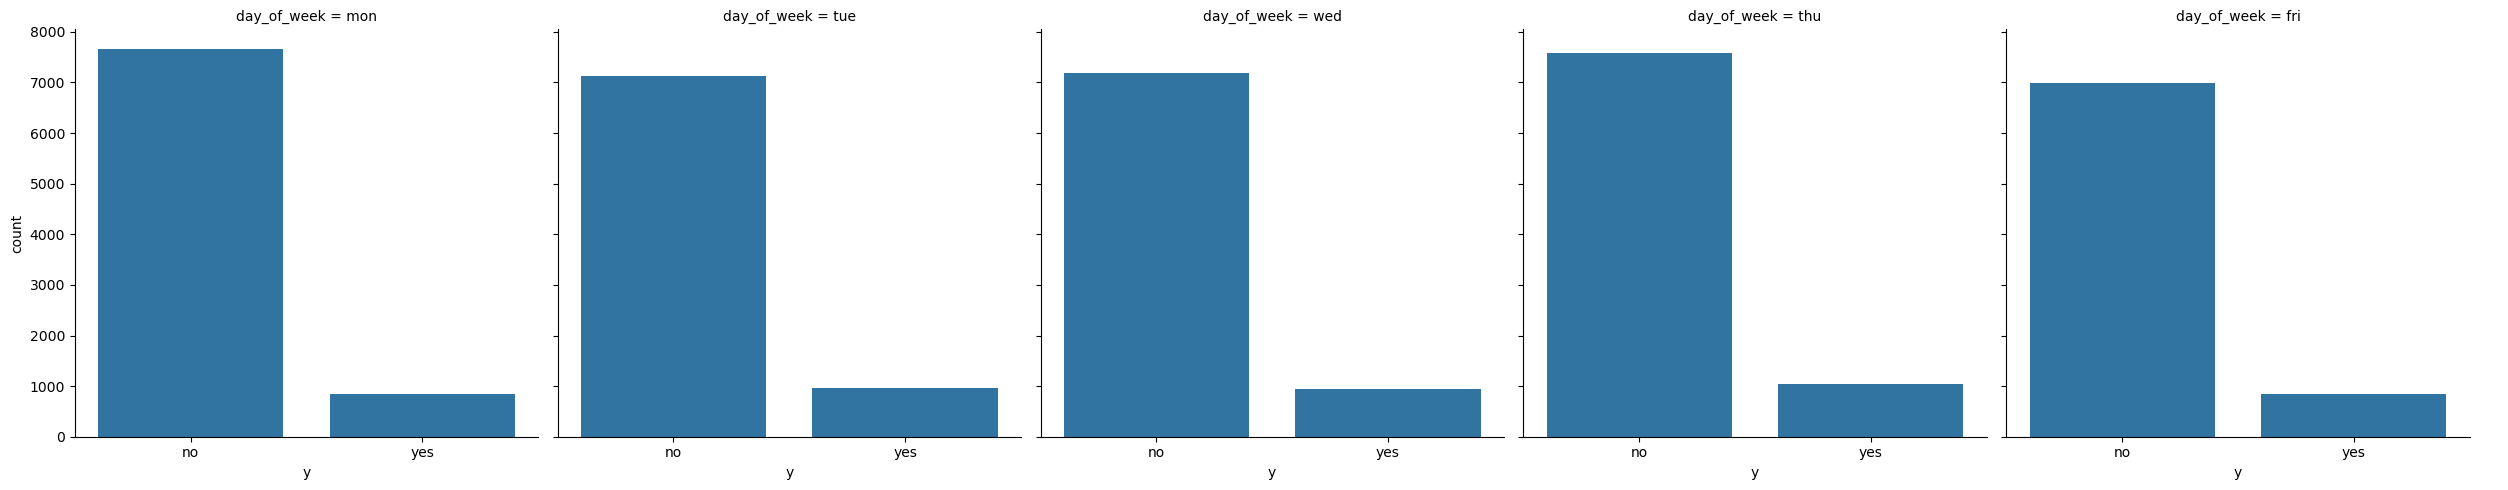

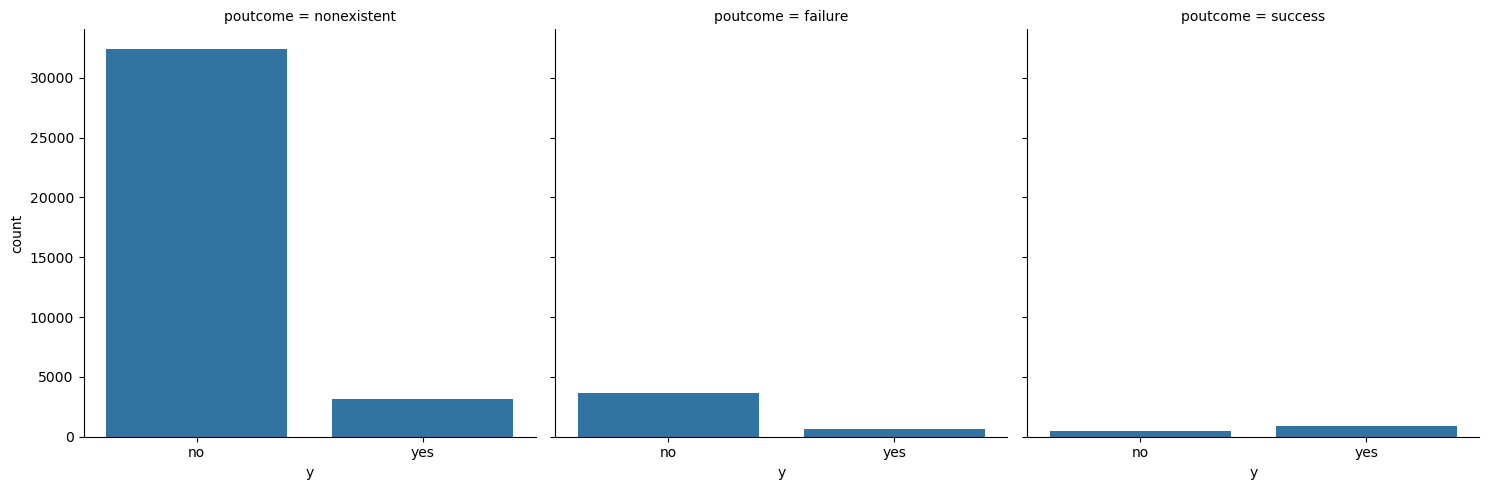

In [33]:
for column in categorical_columns_removed:
    sns.catplot(x='y', col=column, kind='count', data=data)

.

***Plots for 'job', 'education', 'month'***

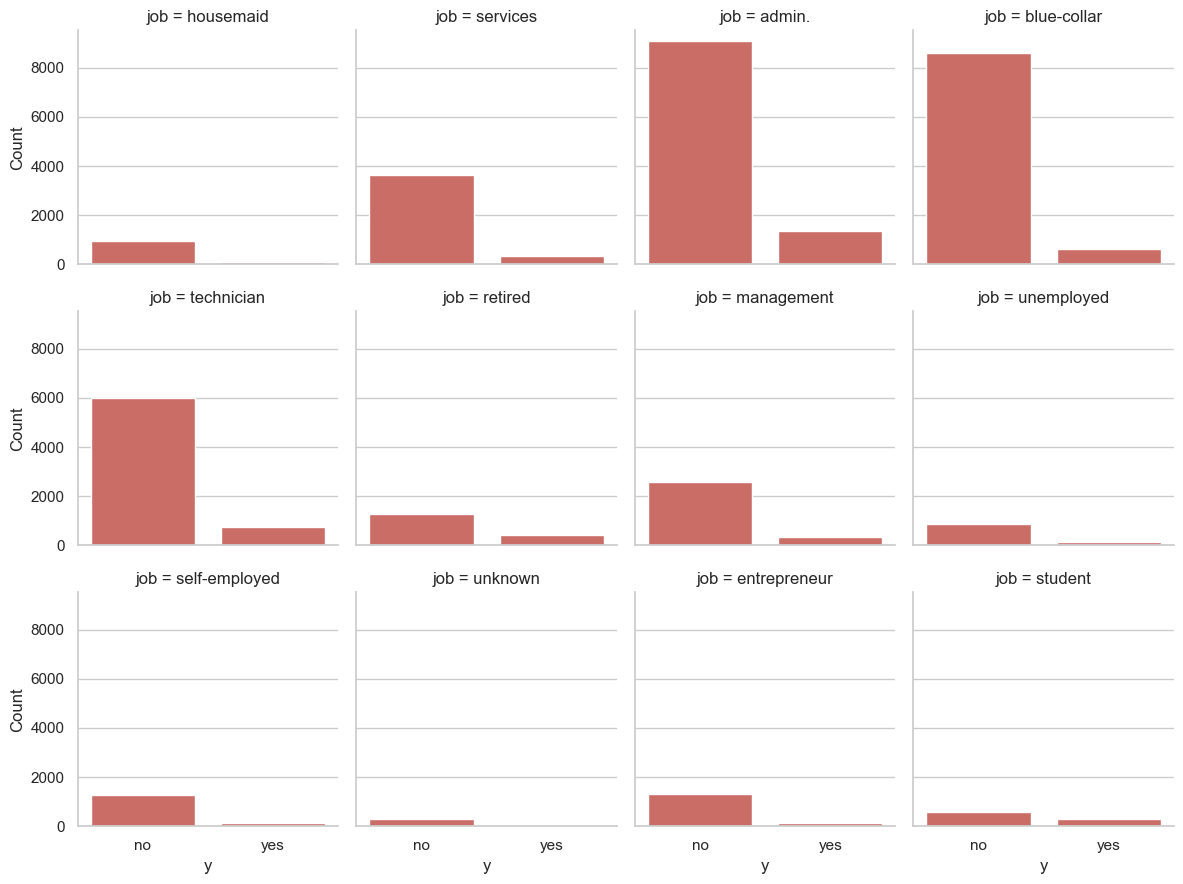

In [35]:
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")

palette = sns.color_palette("hls", len(data['y'].unique()))  # Adjust palette if needed

g = sns.FacetGrid(data, col="job", col_wrap=4, hue='y')
g.map(sns.countplot, "y", palette=palette)  # Pass the color palette
g.set_axis_labels("y", "Count")
plt.show()

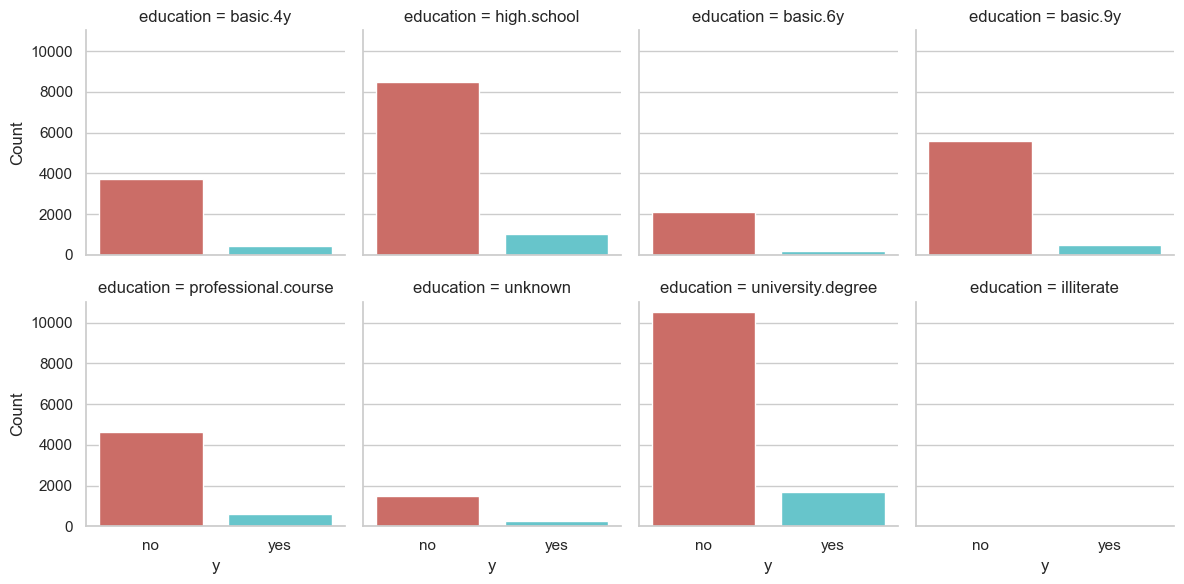

In [36]:
sns.set_theme(style="whitegrid")

palette = sns.color_palette("hls", len(data['y'].unique()))  # Adjust palette if needed

g = sns.FacetGrid(data, col="education", col_wrap=4)
g.map(sns.countplot, "y", palette=palette)  # Pass the color palette
g.set_axis_labels("y", "Count")
plt.show()

In [37]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'Year', 'y'],
      dtype='object')

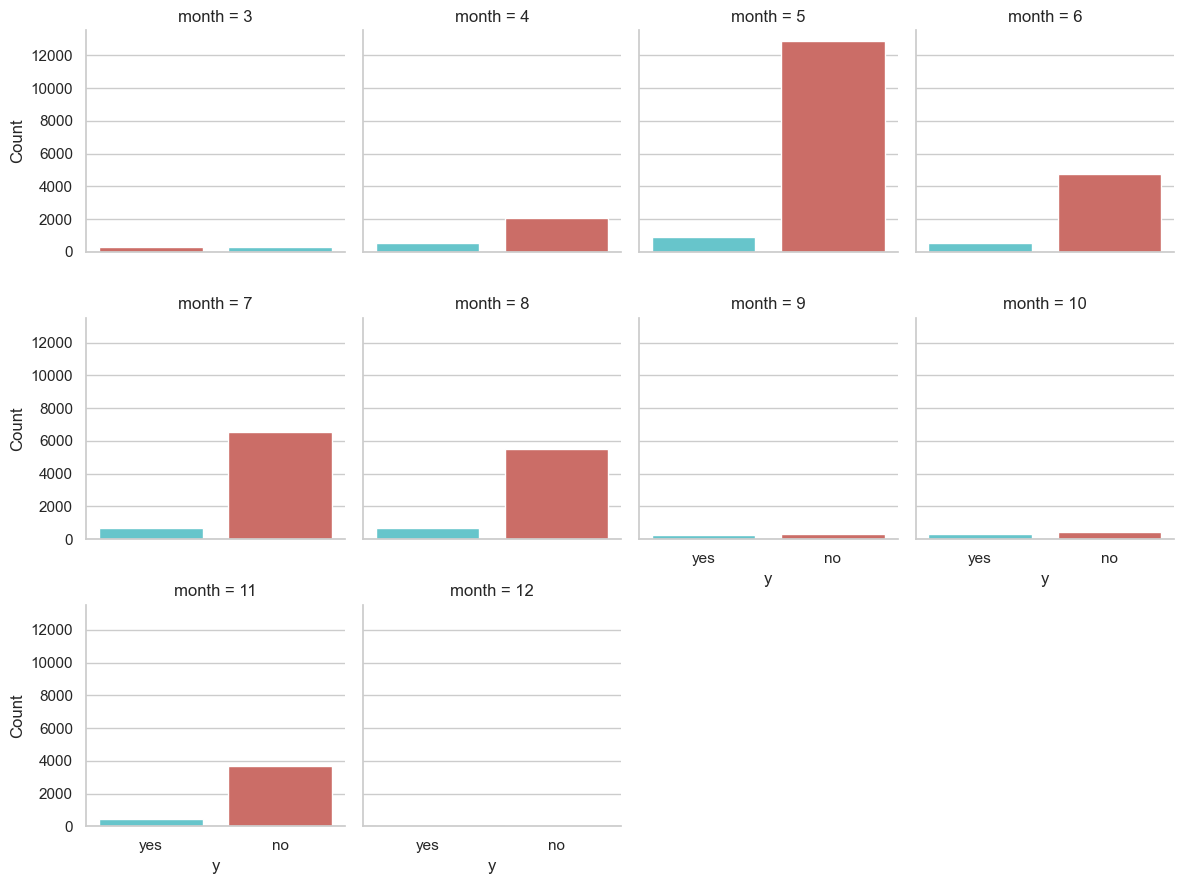

In [38]:
sns.set_theme(style="whitegrid")

palette = sns.color_palette("hls", len(data['y'].unique()))  # Adjust palette if needed
# data
g = sns.FacetGrid(data, col="month", col_wrap=4)
g.map(sns.countplot, "y", palette=palette)  # Pass the color palette
g.set_axis_labels("y", "Count")
plt.show()

In [39]:
grouped_data = data.groupby(['month','y'])
group_counts = grouped_data.size() 
group_counts2 = group_counts.reset_index() #transforma a estructura de dataframe
group_counts2.columns = ['month_Column', 'y', 'case_count'] #renombro la última columna pq al hacer groupby no tiene nombre.
group_counts2

,month_Column,y,case_count
0,3,no,270
1,3,yes,276
2,4,no,2093
3,4,yes,539
4,5,no,12883
5,5,yes,886
6,6,no,4759
7,6,yes,559
8,7,no,6525
9,7,yes,649


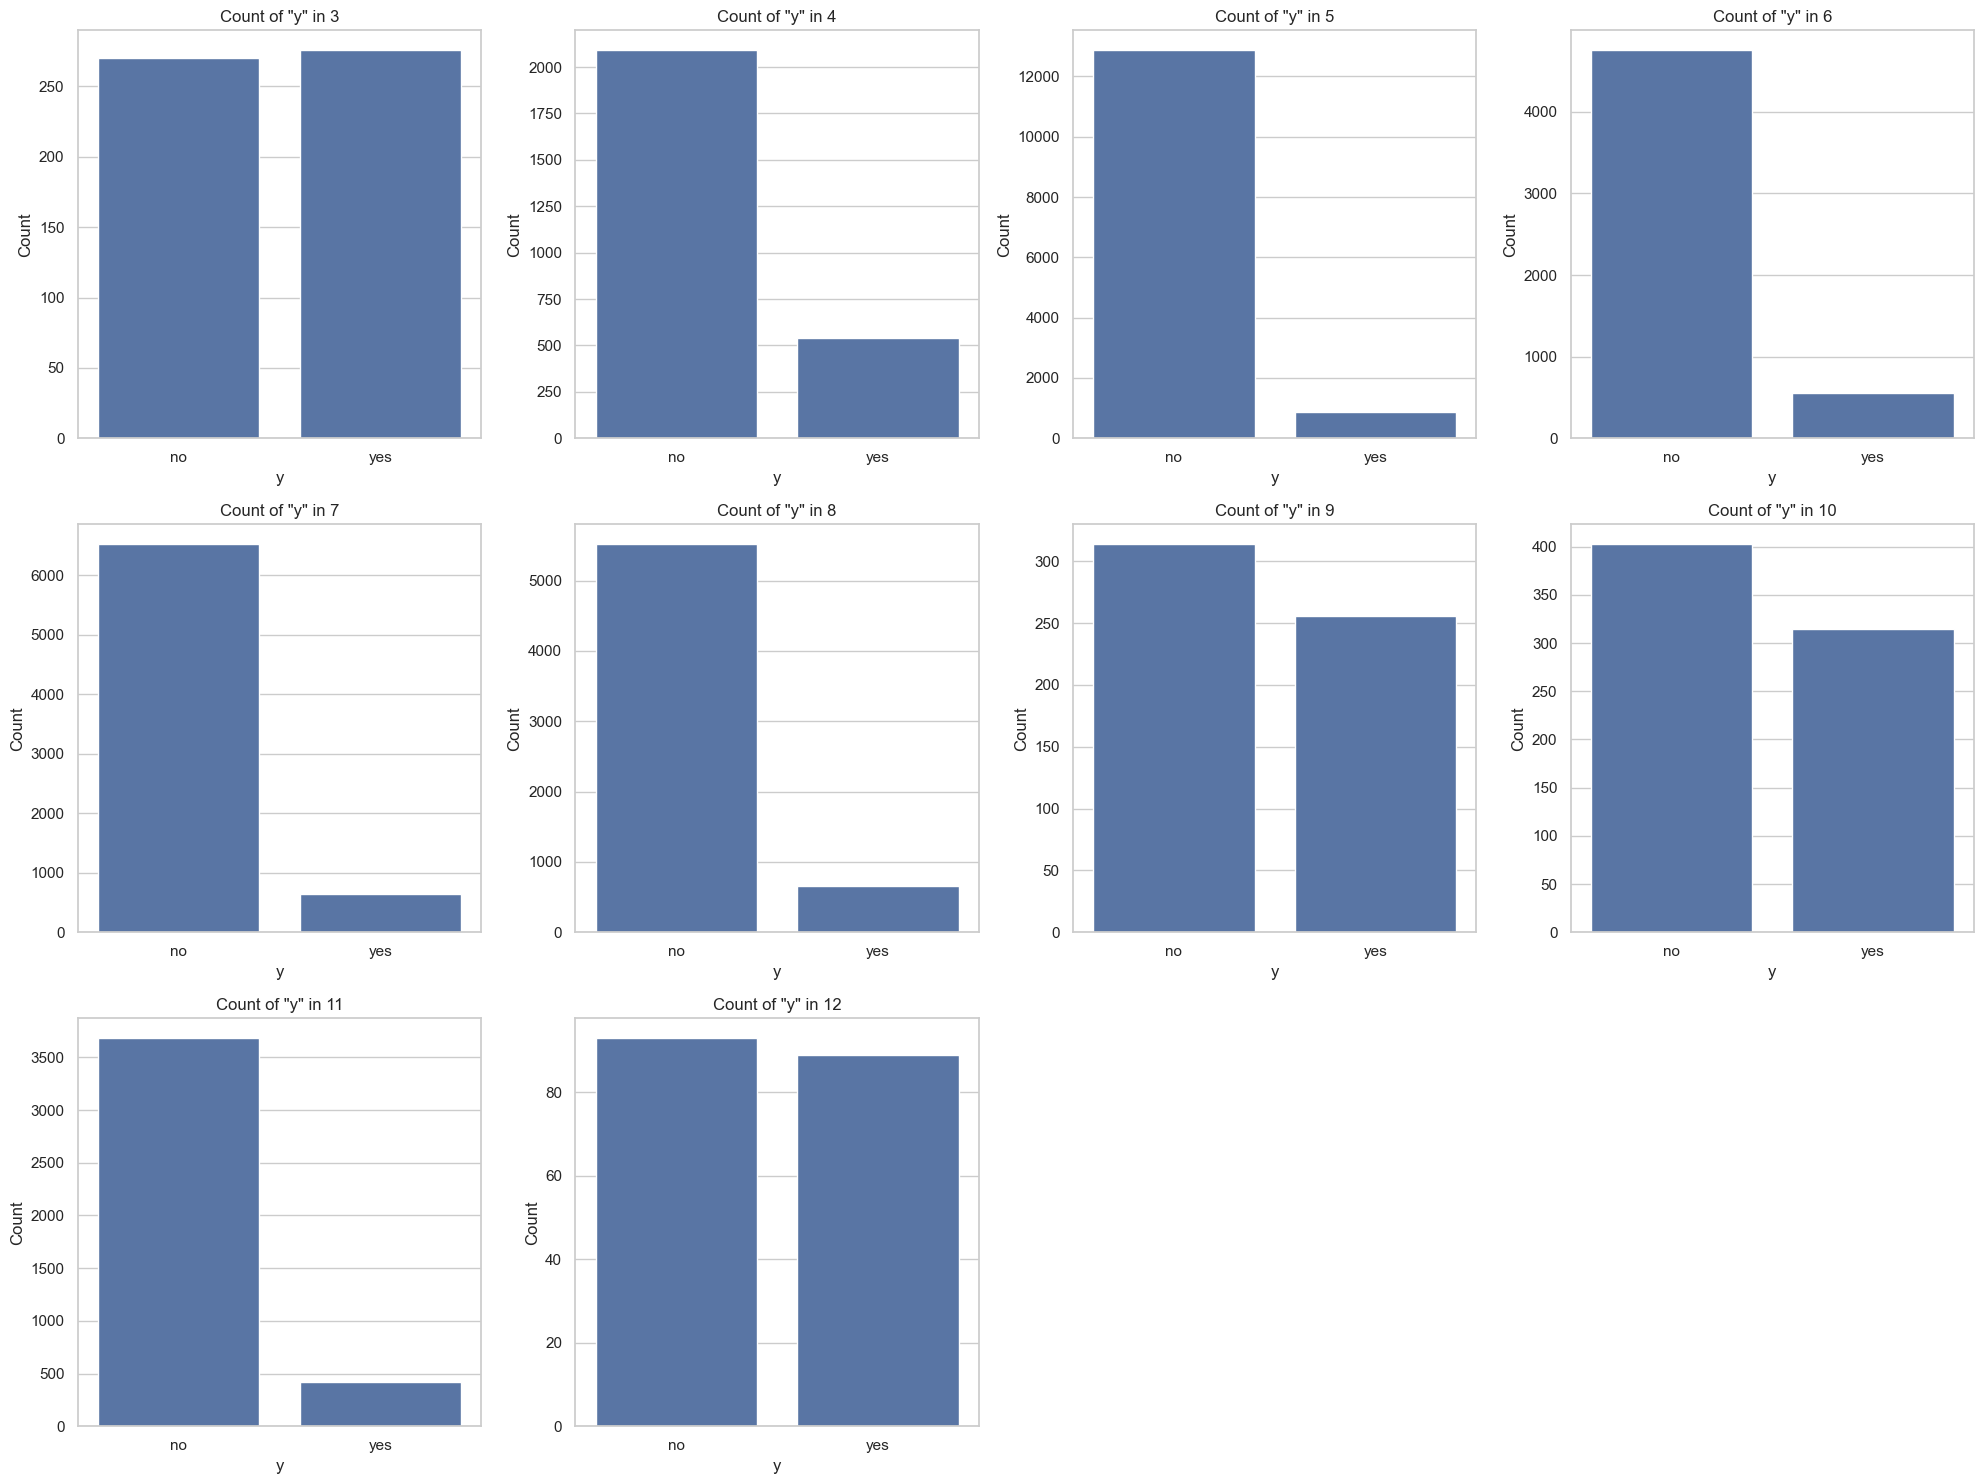

In [40]:
# # prueba de gráfico a nivel MES (sin dividir por año), que nos permite visualizar en forma más comparativa cada mes.
# # No es válido hacer un gráfico que sea una línea de tiempo o los gráficos mensuales uno al lado del otro
# # porque al estar desbalanceado lo que nos interesa es la relación porcentual entre cada mes.

unique_months = group_counts2['month_Column'].unique()  # Unique months
num_months = len(unique_months)
cols = 4  # Number of columns
rows = (num_months + cols - 1) // cols  # Calculate the number of rows needed

# Create a single figure for all plots
plt.figure(figsize=(20, 5 * rows))  # Adjust the figure size as needed

for i, month in enumerate(unique_months):
    # Filter data for the current month
    month_data = group_counts2[group_counts2['month_Column'] == month]
    
    # Create a subplot for the current month
    plt.subplot(rows, cols, i + 1)  # Create a grid of subplots
    sns.barplot(x='y', y='case_count', data=month_data)
    plt.title(f'Count of "y" in {month}')  # Customize title with month
    plt.xlabel('y')
    plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


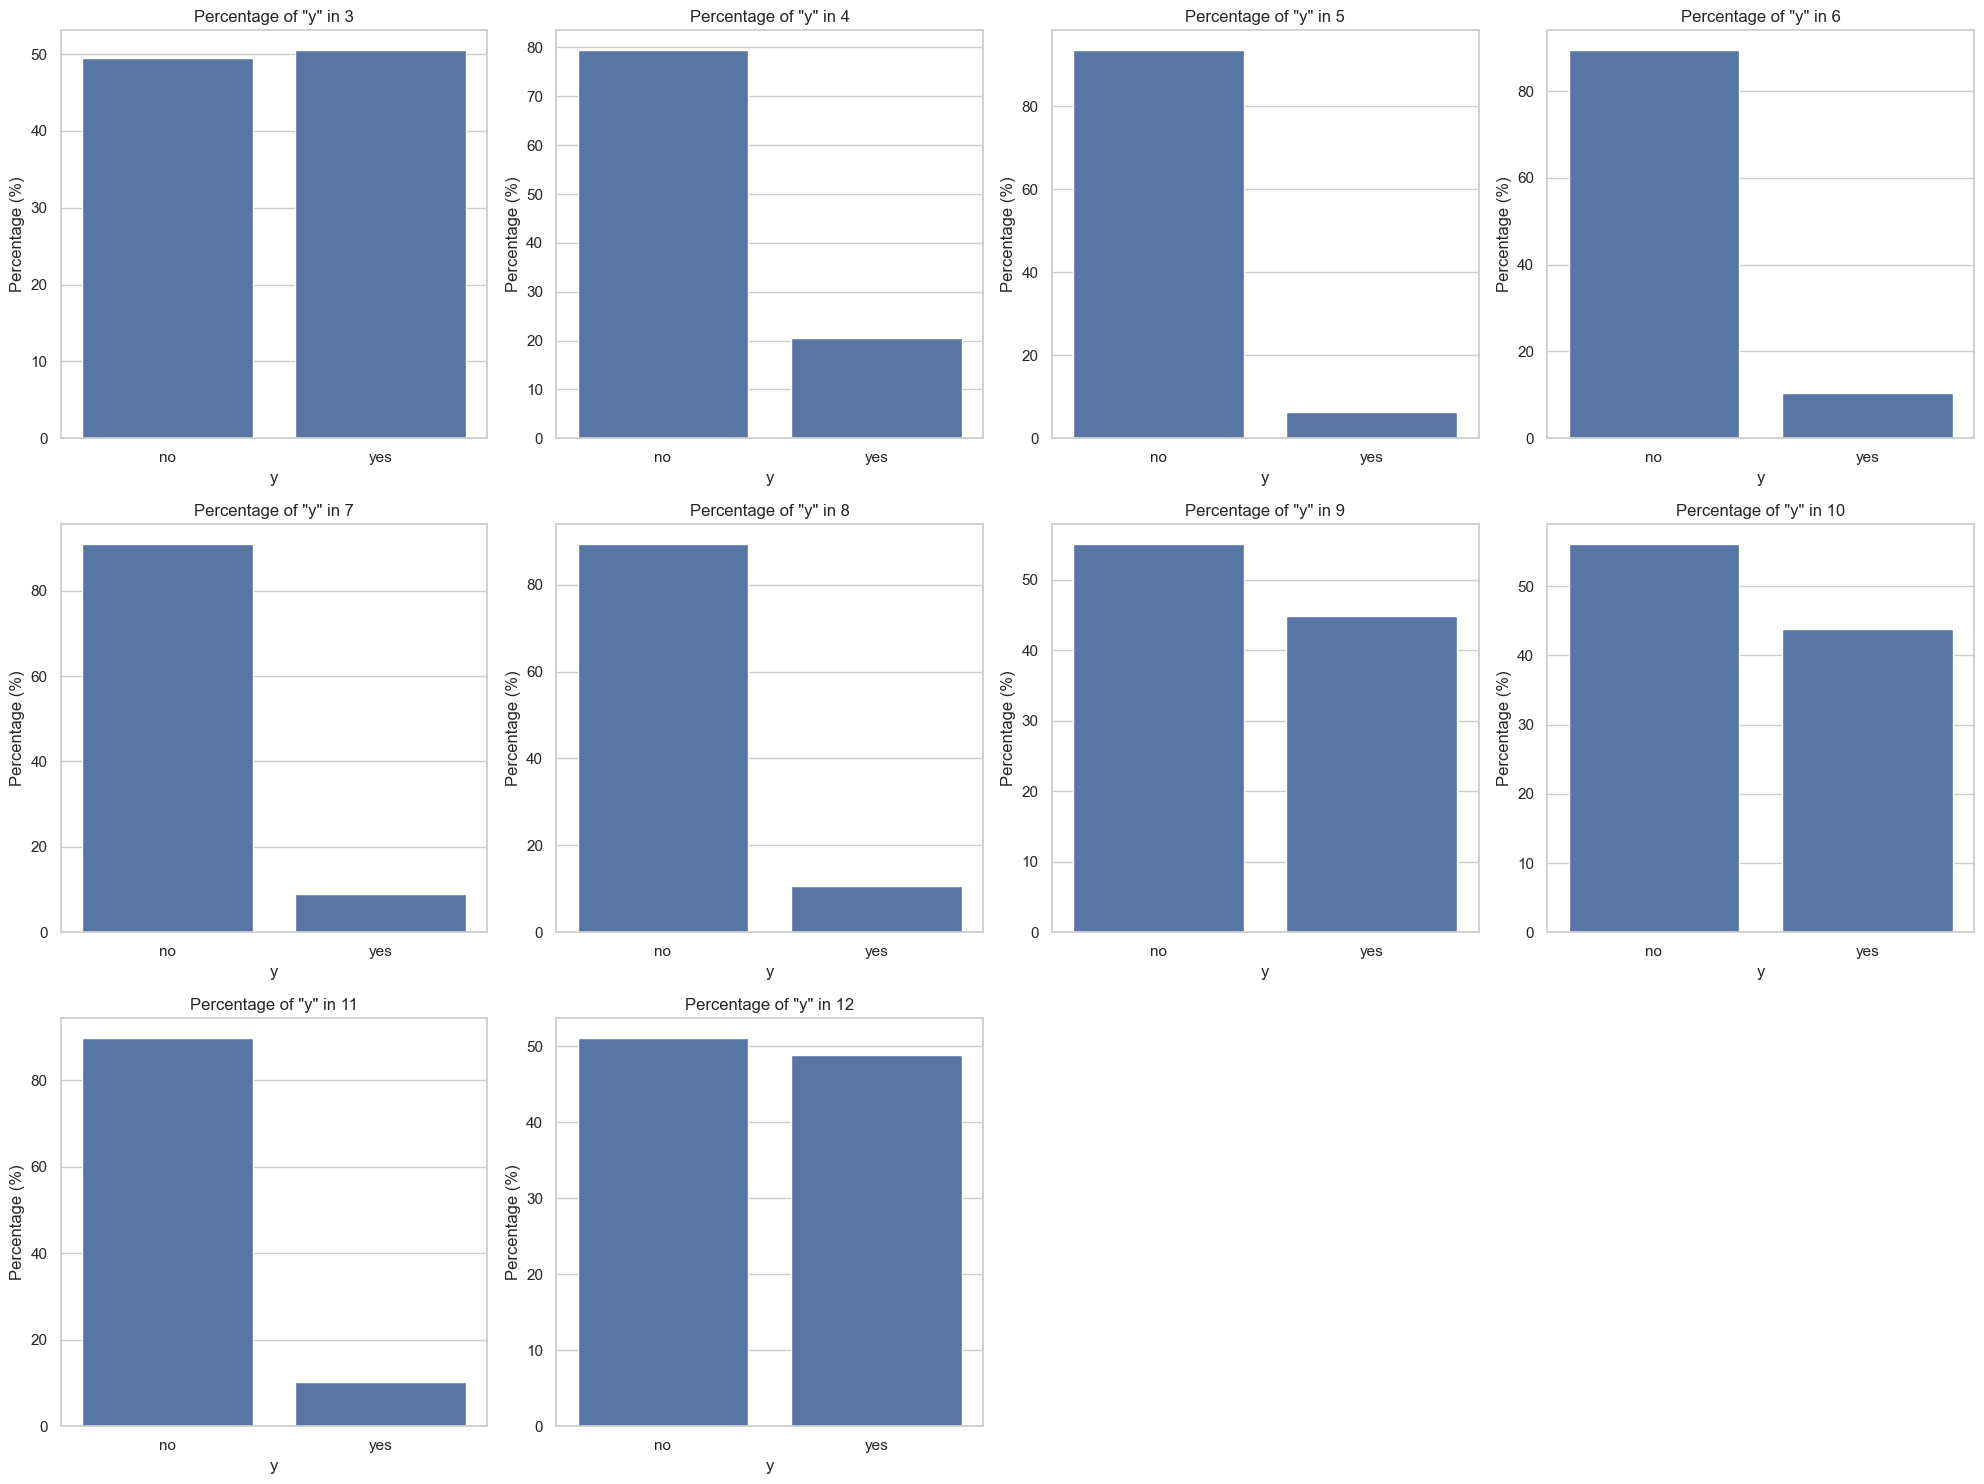

In [41]:
unique_months = group_counts2['month_Column'].unique()  # Unique months
num_months = len(unique_months)
cols = 4  # Number of columns
rows = (num_months + cols - 1) // cols  # Calculate the number of rows needed

# Create a single figure for all plots
plt.figure(figsize=(20, 5 * rows))  # Adjust the figure size as needed

for i, month in enumerate(unique_months):
    # Filter data for the current month
    month_data = group_counts2[group_counts2['month_Column'] == month]

    # Calculate total counts and percentages
    total_count = month_data['case_count'].sum()
    month_data['percentage'] = (month_data['case_count'] / total_count) * 100

    # Create a subplot for the current month
    plt.subplot(rows, cols, i + 1)  # Create a grid of subplots
    sns.barplot(x='y', y='percentage', data=month_data)
    plt.title(f'Percentage of "y" in {month}')  # Customize title with month
    plt.xlabel('y')
    plt.ylabel('Percentage (%)')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [42]:
# Hasta acá está bien hecho. Se muestra arriba la relación porcentual.

In [43]:
#Prueba a nivel año-mes.
year_month_df_aux = data.groupby(['Year','month','y'])
year_month_df = year_month_df_aux.size() 
year_month_df = year_month_df.reset_index() #transforma a estructura de dataframe
year_month_df.columns.values[3] = 'case_count'
year_month_df['Year_month'] = year_month_df['Year'].astype(str) + '_' + year_month_df['month'].astype(str)
year_month_df


,Year,month,y,case_count,Year_month
0,2008,5,no,7523,2008_5
1,2008,5,yes,240,2008_5
2,2008,6,no,4186,2008_6
3,2008,6,yes,188,2008_6
4,2008,7,no,6278,2008_7
5,2008,7,yes,407,2008_7
6,2008,8,no,4904,2008_8
7,2008,8,yes,271,2008_8
8,2008,10,no,25,2008_10
9,2008,10,yes,42,2008_10


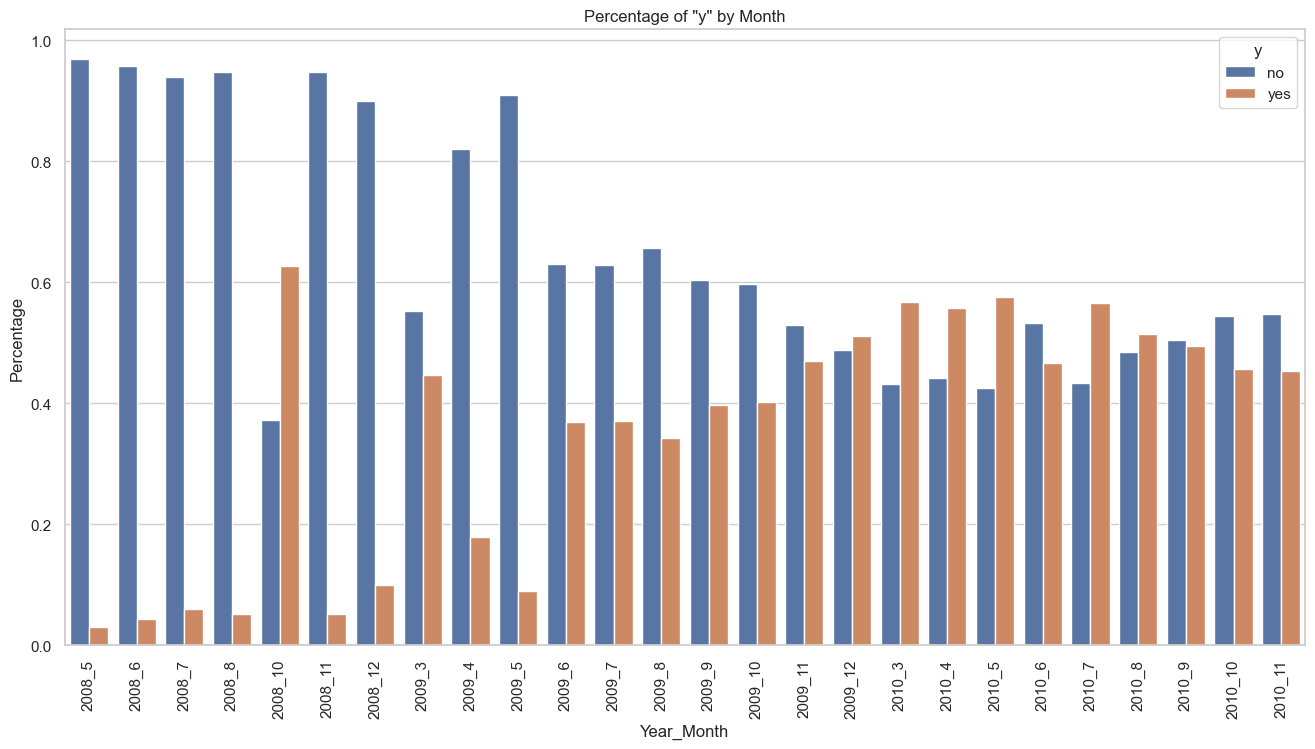

In [45]:
test_df = year_month_df.copy()
test_df = test_df.drop(['Year','month'],axis=1)
test_df['totals_p_month'] = test_df.groupby(['Year_month'])['case_count'].transform('sum')
test_df['percentages'] = test_df['case_count'] / test_df['totals_p_month']

# Set the figure size (width, height)
plt.figure(figsize=(16, 8))

# Create the barplot
sns.barplot(x='Year_month', y='percentages', hue='y', data=test_df)

# Set labels and title
plt.xlabel('Year_Month')
plt.ylabel('Percentage')
plt.title('Percentage of "y" by Month')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [46]:
# Calculate the total case count for each Year_month
year_month_df_aux2 = test_df.copy()
year_month_df_aux2['totals_month'] = year_month_df_aux2.groupby(['Year_month'])['case_count'].transform('sum')
year_month_df_aux2
# # Create a new column for the percentage of the total case count per Year_month
# year_month_df['percentage'] = (year_month_df['case_count'] / year_month_totals) * 100

# # Display the updated DataFrame
# print(year_month_df.head())


,y,case_count,Year_month,totals_p_month,percentages,totals_month
0,no,7523,2008_5,7763,0.969084,7763
1,yes,240,2008_5,7763,0.030916,7763
2,no,4186,2008_6,4374,0.957019,4374
3,yes,188,2008_6,4374,0.042981,4374
4,no,6278,2008_7,6685,0.939117,6685
5,yes,407,2008_7,6685,0.060883,6685
6,no,4904,2008_8,5175,0.947633,5175
7,yes,271,2008_8,5175,0.052367,5175
8,no,25,2008_10,67,0.373134,67
9,yes,42,2008_10,67,0.626866,67


In [47]:
merged_df_test = pd.merge(group_counts2, data_test2, on='month_Column')


NameError: name 'data_test2' is not defined

In [ ]:
merged_df_test1 = merged_df_test.copy()
merged_df_test1['normalized'] = merged_df_test1['case_count_x']/merged_df_test1['case_count_y']

In [ ]:
merged_df_test1

In [ ]:
unique_months = merged_df_test1['month_Column'].unique()  # Get unique month values

for month in unique_months:
  # Filter data for the current month
  month_data = merged_df_test1[merged_df_test1['month_Column'] == month]
  sns.barplot(x='y', y='normalized', data=month_data)
  plt.title(f'Count of "y" in {month}')  # Customize title with month
  plt.xlabel('y')
  plt.ylabel('Count')
  plt.show()

In [ ]:
merged_df_test1

In [ ]:
#ESTE ES EL GRÁFICO QUE NOS INTERESA, ESTÁ NORMALIZADO Y ES MES A MES.

sns.barplot(x='month_Column', y='normalized', hue='y', data=merged_df_test1)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of "y" by Month')
plt.show()